## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch

## Load a model

In [3]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames+hodnames

# Specify model configuration
nbody = 'mtnglike'
sim = 'fastpm'
save_dir = join(wdir, nbody, sim, 'models')

In [4]:
# Specify data dtype
tracer = 'mtng_lightcone'
summaries = ['Pk0']
summary = '+'.join(summaries)
kmax = 0.4
modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
os.listdir(modelpath)

['posterior.pkl',
 'loss.jpg',
 'true_logprobs.npy',
 'plot_coverage.jpg',
 'theta_test.npy',
 'x_test.npy',
 'plot_true_logprobs.jpg',
 'ranks_histogram.jpg',
 'plot_single_posterior.jpg',
 'plot_TARP.jpg',
 'summary.json',
 'plot_predictions.jpg',
 'posterior_samples.npy']

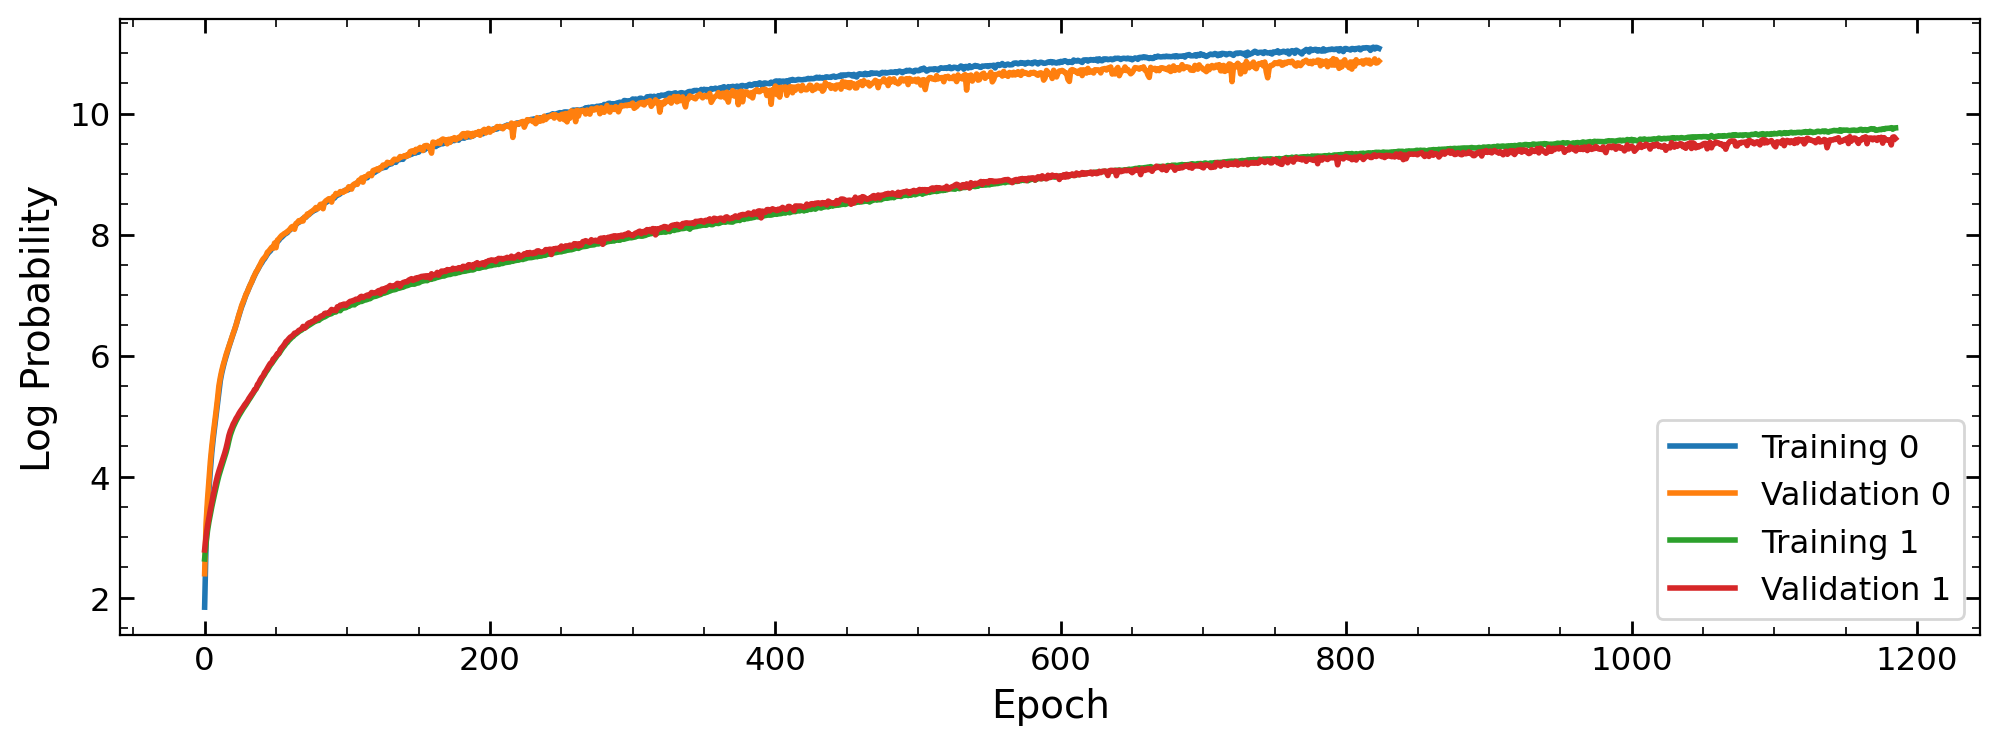

In [7]:
# Load training history
summary_file = join(modelpath, 'summary.json')
with open(summary_file, 'r') as f:
    history = json.load(f)
f, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(len(history)):
    ax.plot(history[i]['training_log_probs'], label=f'Training {i}')
    ax.plot(history[i]['validation_log_probs'], label=f'Validation {i}')
ax.set(xlabel='Epoch', ylabel='Log Probability')
ax.legend()

[Text(0.5, 0, 'True $\\Omega_m$'), Text(0, 0.5, 'Predicted $\\Omega_m$')]

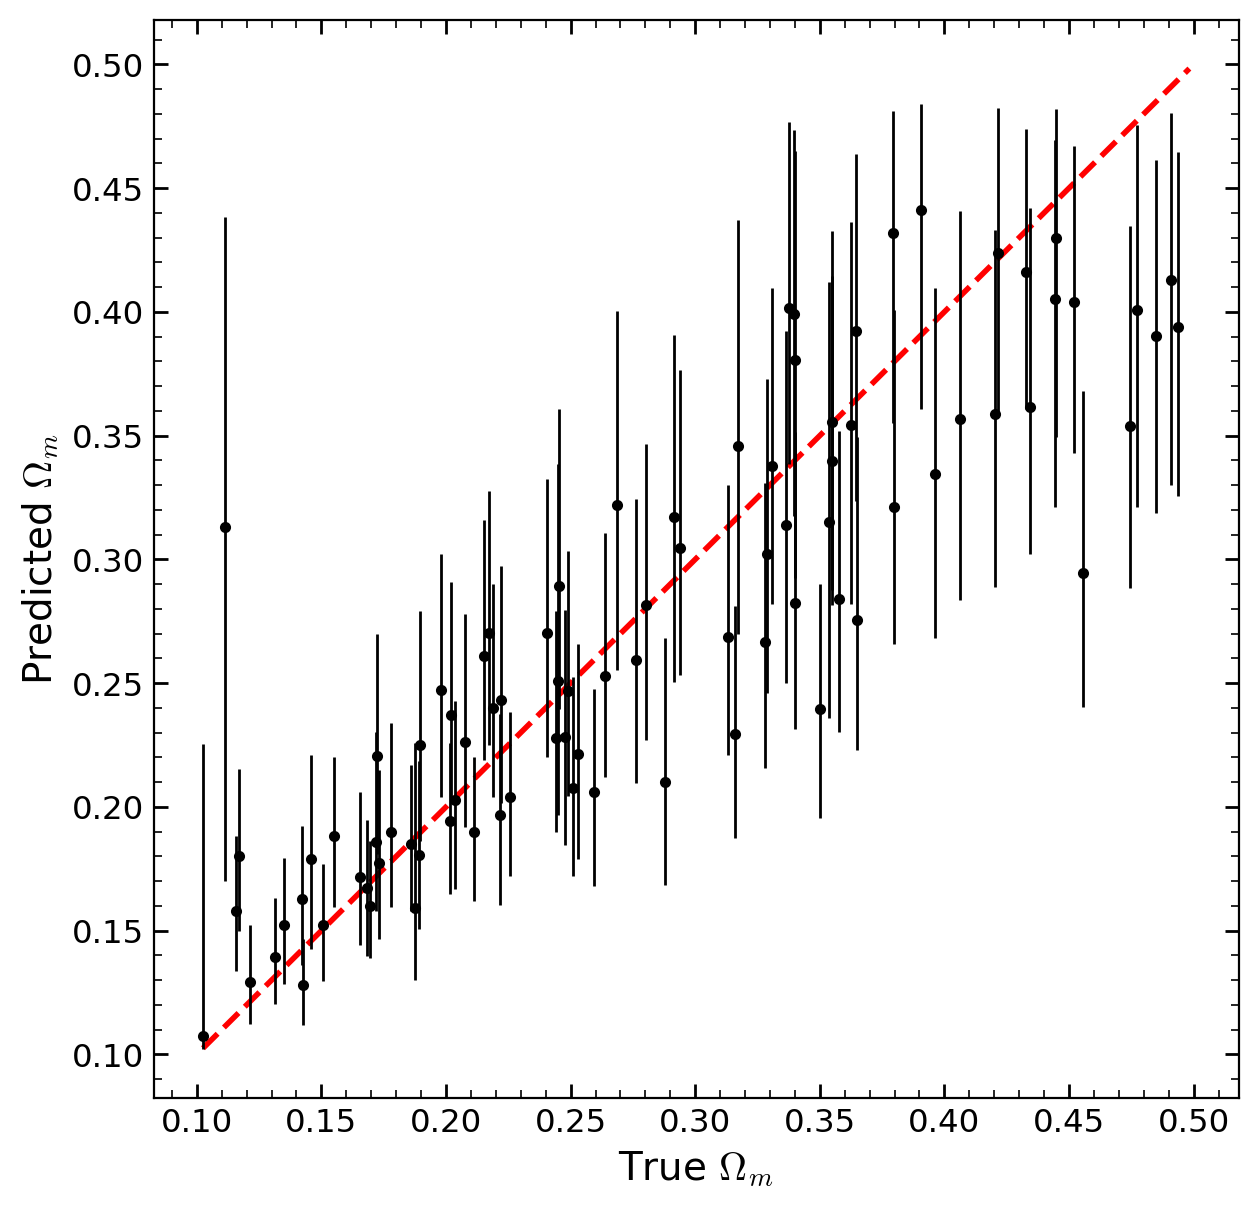

In [10]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

ss = 10
pind = 0

f, ax = plt.subplots(1, 1, figsize=(7, 7))
minx, maxx = ytest[:,pind].min(), ytest[:,pind].max()
ax.plot([minx, maxx], [minx, maxx], 'r--')
ax.plot(ytest[::ss, pind], percs[1, ::ss, pind], 'k.')
ax.errorbar(ytest[::ss, pind], percs[1, ::ss, pind], yerr=[percs[1, ::ss, pind]-percs[0, ::ss, pind],
            percs[2, ::ss, pind]-percs[1, ::ss, pind]], fmt='none', ecolor='k', elinewidth=1)
ax.set(xlabel=f'True {cosmonames[pind]}', ylabel=f'Predicted {cosmonames[pind]}')

In [18]:
# Load model posterior
with open(join(modelpath, 'posterior.pkl'), 'rb') as f:
    posterior = pickle.load(f).to('cuda')
# print(posterior)

INFO:root:Sampling models with [1568, 432] samples each.
Drawing 1568 posterior samples: 1704it [00:00, 19193.73it/s]            
Drawing 432 posterior samples: 493it [00:00, 17710.98it/s]            


[Text(0.5, 0, '$\\Omega_m$'), Text(0, 0.5, '$\\sigma_8$')]

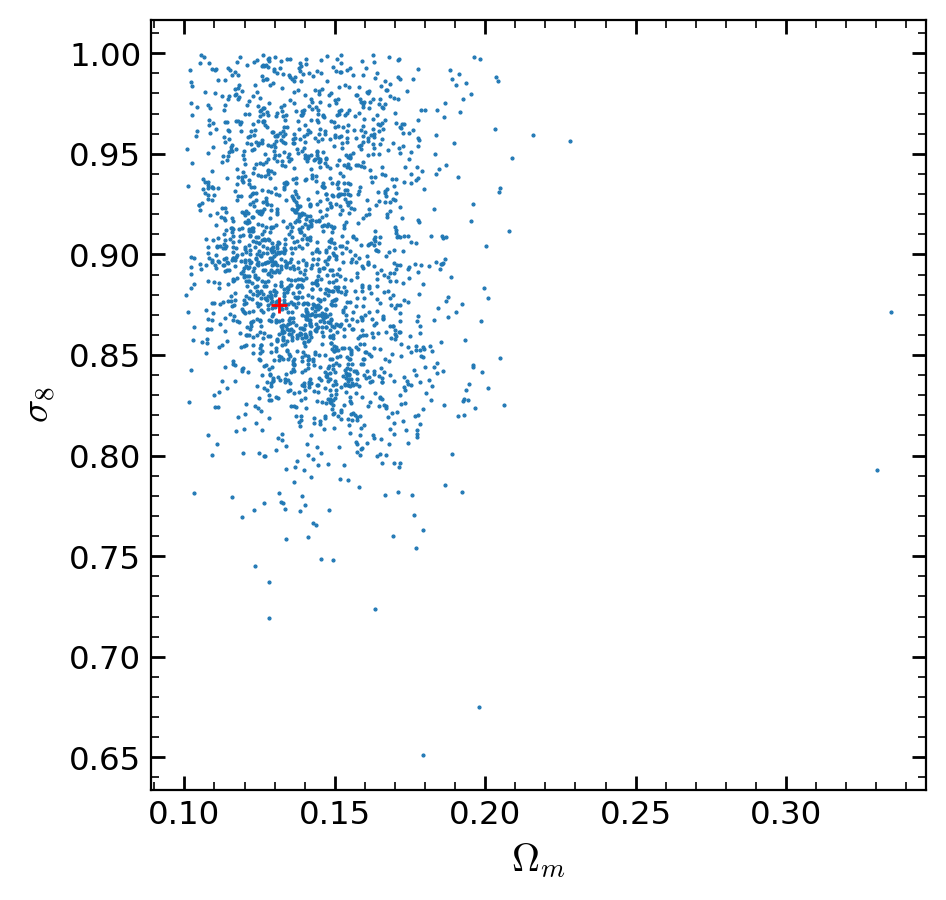

In [25]:
# Predict on a test point
ind = 10
x0 = torch.Tensor(xtest[ind]).to('cuda')
samp0 = posterior.sample(x=x0, shape=(2000,)).to('cpu')

f, ax = plt.subplots(figsize=(5,5))
ax.scatter(samp0[:, 0], samp0[:, 4], s=1, marker='.')
ax.plot(ytest[ind,0], ytest[ind,4], 'r+')
ax.set(xlabel=cosmonames[0], ylabel=cosmonames[4])

## Load an observed summary

In [52]:
# Load an observed summary
simpath = join(wdir, 'mtng', 'nbody', 'L3000-N384', '0', 'diag')
with h5py.File(join(simpath, 'mtng_lightcone/hod00000_aug00000.h5'), 'r') as f:
    k = f['Pk_k3D'][:]
    Pk0 = f['Pk'][:, 0]  # get the monopole
summ = {'k': k, 'value': Pk0}

mtngcosmo = [0.308900,0.048600,0.677400,0.966700,0.815900]


In [27]:
# Preprocess the summary
from cmass.infer.loaders import preprocess_Pk
xin = preprocess_Pk([summ], kmax)[0]

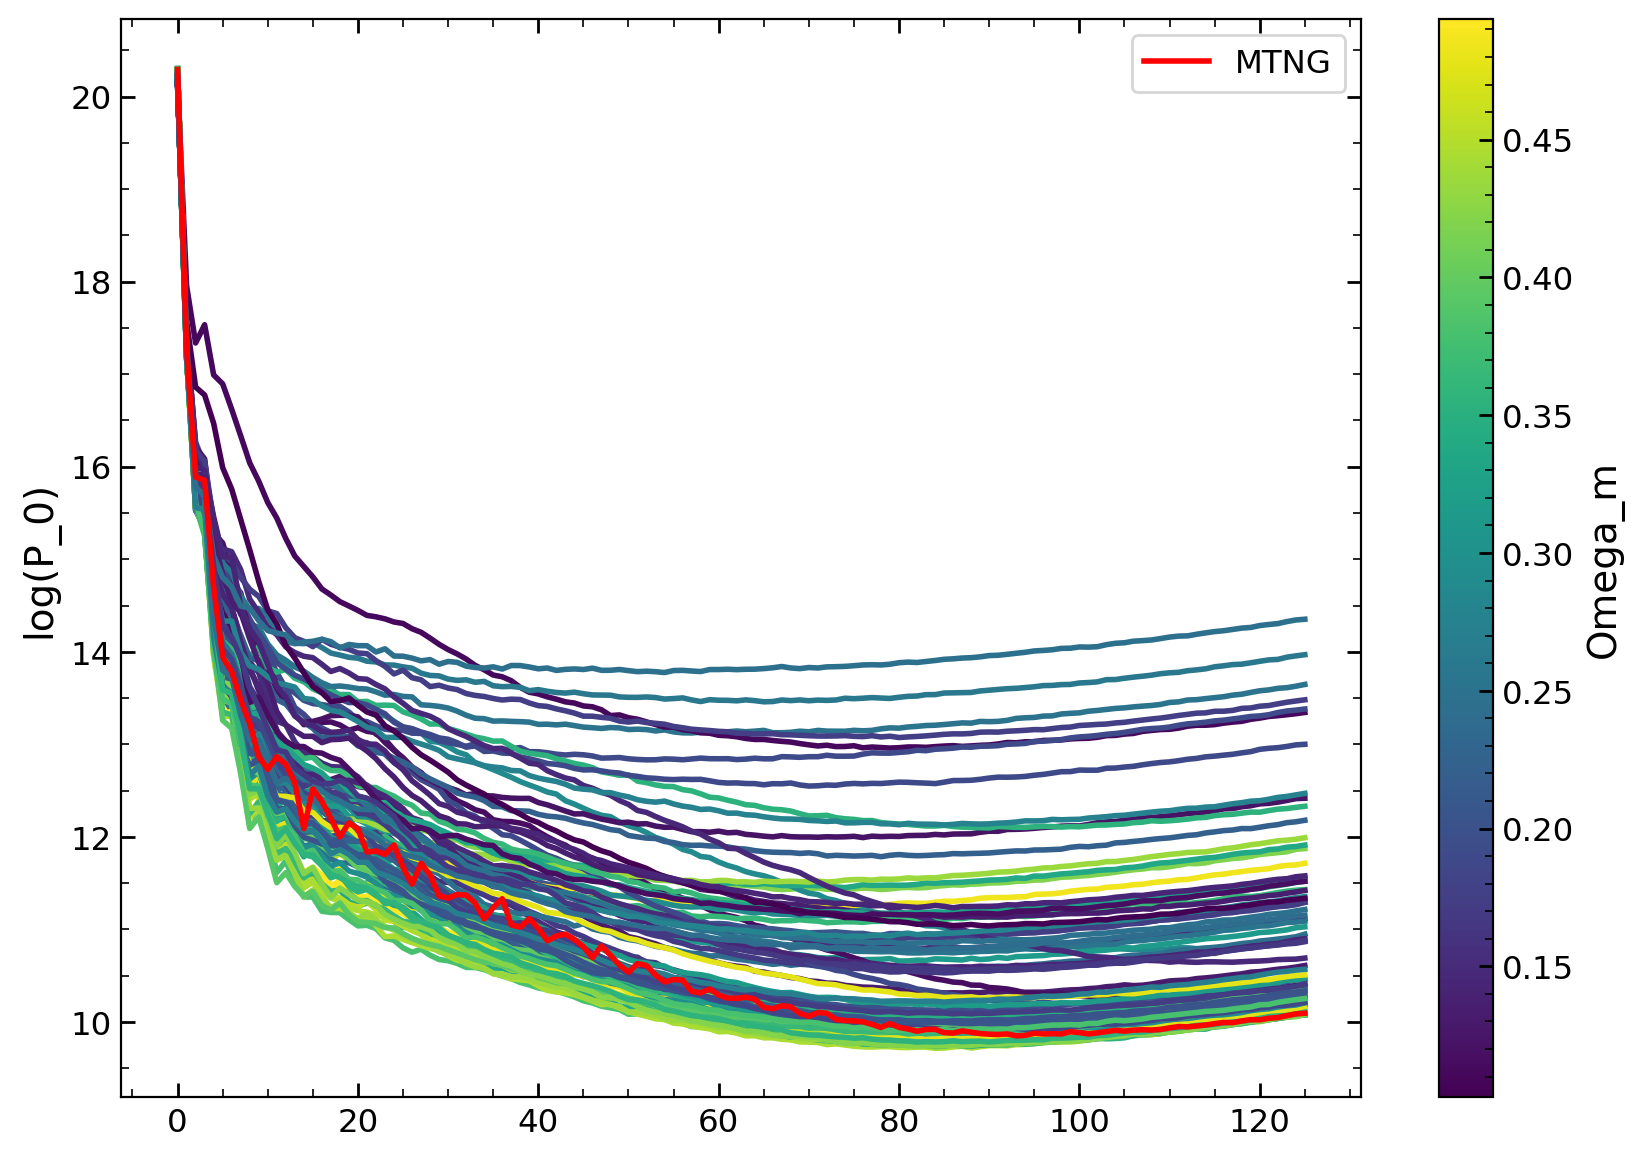

In [46]:
import matplotlib.colors as mcolors

ss=10

f, ax = plt.subplots(figsize=(10,7))
Omega_m = ytest[::10,0]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=Omega_m.min(), vmax=Omega_m.max())

for i, t in enumerate(xtest[::10]):
    ax.plot(t, color=cmap(norm(Omega_m[i])))
ax.plot(xin, color='r', label='MTNG')
ax.set_ylabel('log(P_0)')
ax.legend()
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='Omega_m')

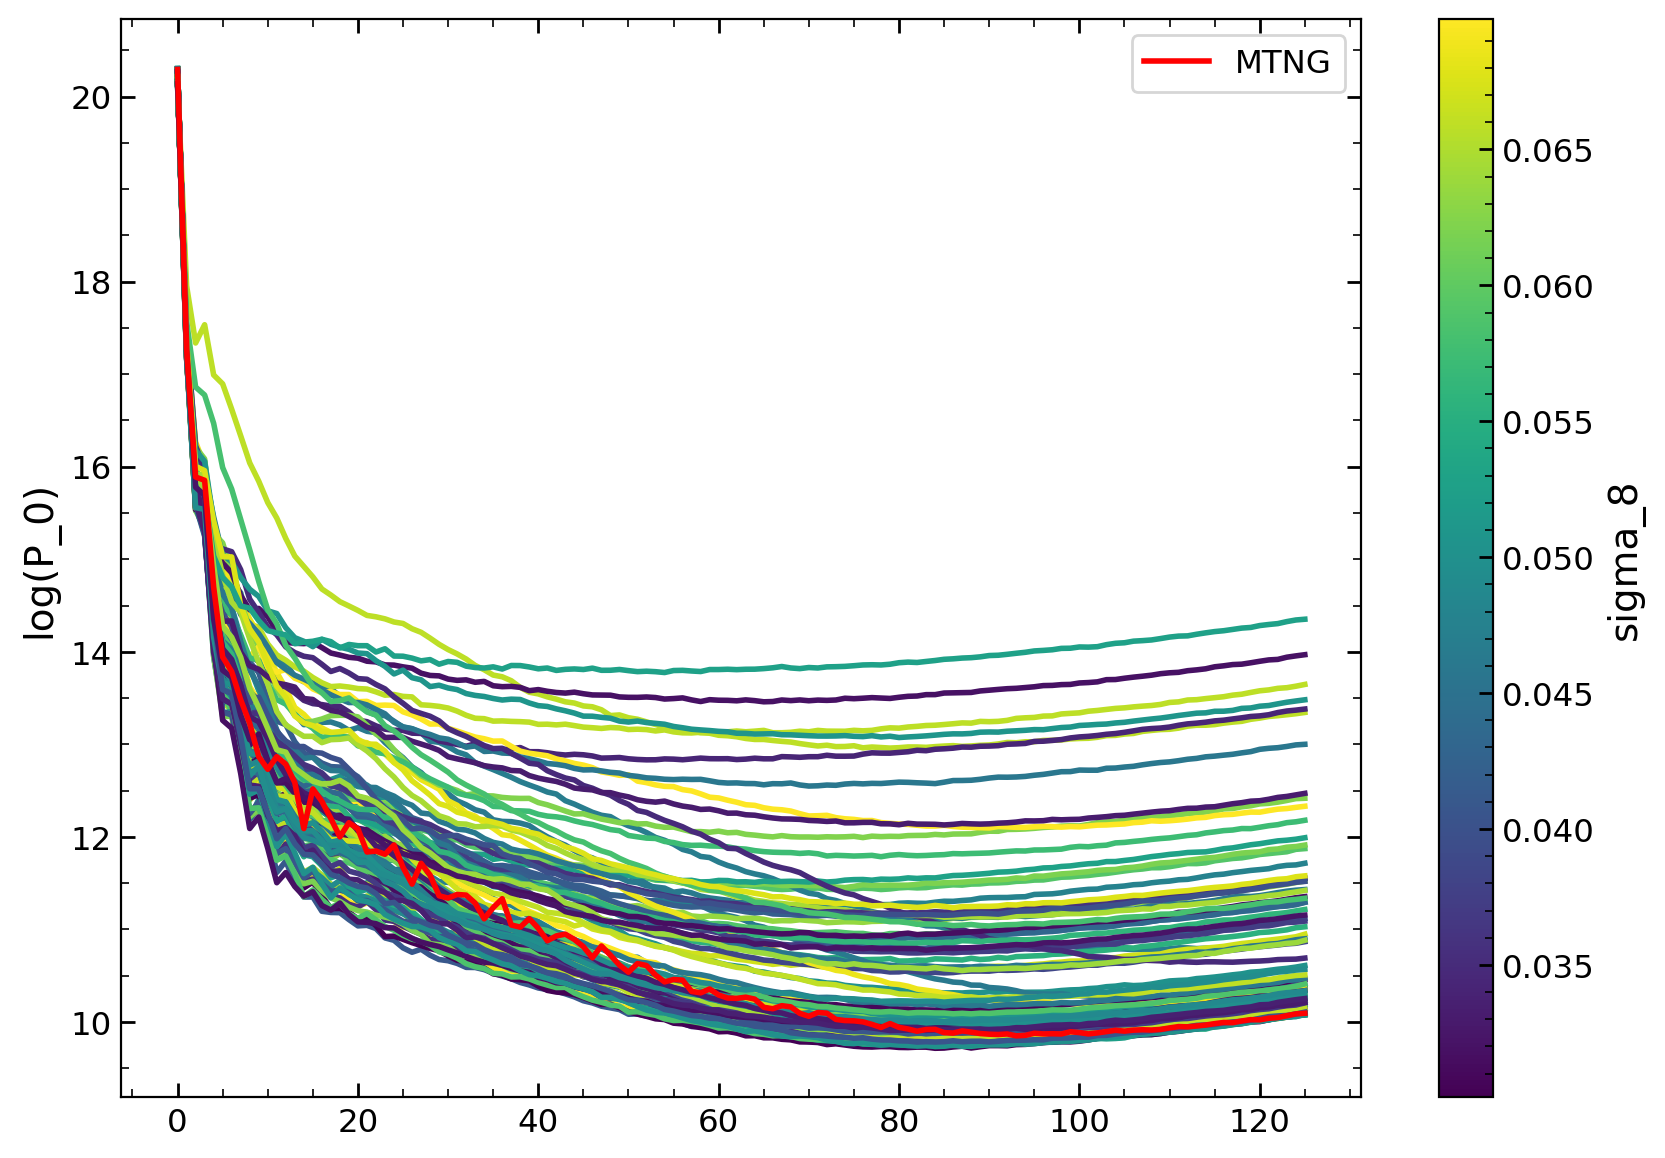

In [47]:
import matplotlib.colors as mcolors

ss=10

f, ax = plt.subplots(figsize=(10,7))
sig8 = ytest[::10,1]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=sig8.min(), vmax=sig8.max())

for i, t in enumerate(xtest[::10]):
    ax.plot(t, color=cmap(norm(sig8[i])))
ax.plot(xin, color='r', label='MTNG')
ax.set_ylabel('log(P_0)')
ax.legend()
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='sigma_8')

INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1407it [00:00, 15709.84it/s]           
Drawing 216 posterior samples: 249it [00:00, 6030.72it/s]             


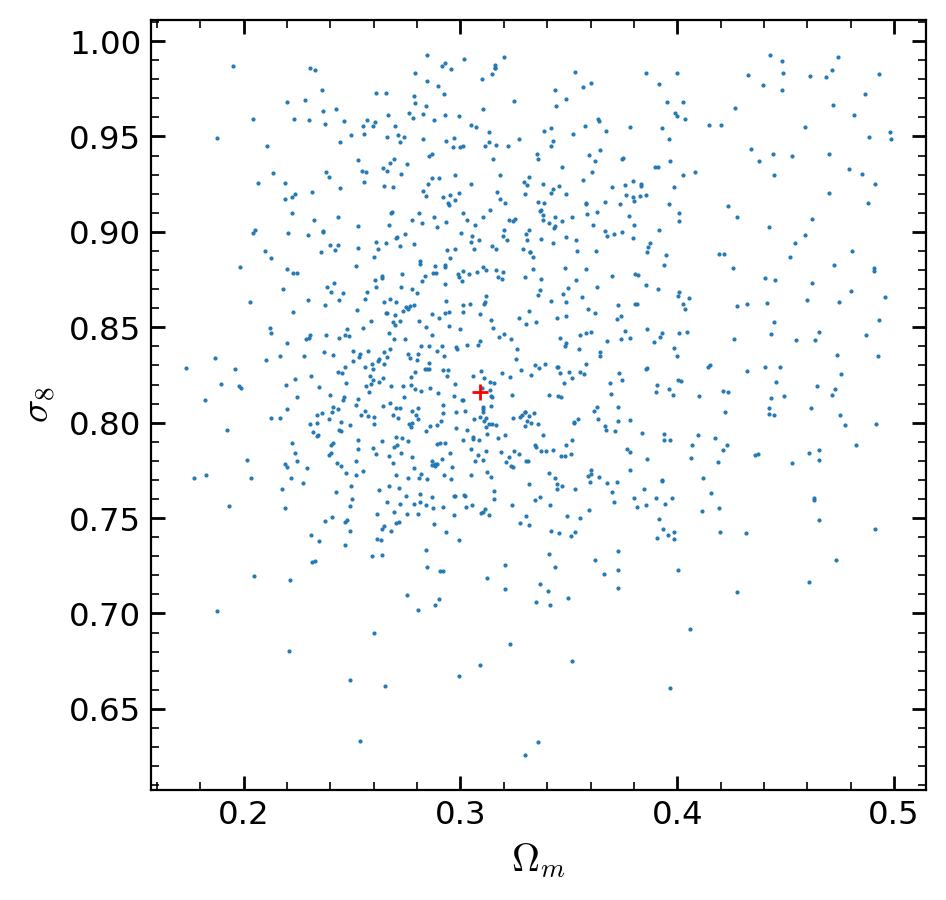

In [53]:
# Sample the posterior
sampobs = posterior.sample(x=xin, shape=(1000,)).to('cpu')
f, ax = plt.subplots(figsize=(5,5))
ax.scatter(sampobs[:, 0], sampobs[:, 4], s=1, marker='.')
ax.plot(mtngcosmo[0], mtngcosmo[4], 'r+')
ax.set(xlabel=cosmonames[0], ylabel=cosmonames[4]);

In [58]:
# Load literature
import pandas as pd
iva = pd.read_csv('/anvil/scratch/x-mho1/cmass-ili/literature/processed/ivanov.csv')
iva = iva.drop('chain', axis=1)
iva

,Omega_m,Omega_b,h,n_s,sigma8
0,0.326309,0.049963,0.672097,1.052404,0.619421
1,0.367858,0.045460,0.707421,0.891898,0.600905
2,0.323497,0.045951,0.710906,0.871478,0.596487
3,0.362327,0.047147,0.684184,0.890990,0.640596
4,0.291084,0.044544,0.712115,1.104797,0.703013
...,...,...,...,...,...
4746,0.316843,0.047880,0.685660,1.039545,0.709020
4747,0.304465,0.047181,0.695522,1.059588,0.735897
4748,0.342598,0.048757,0.690500,0.944009,0.696069
4749,0.312640,0.047880,0.688856,1.060362,0.699524


In [62]:
ltu = pd.DataFrame(sampobs[:,:5], columns=iva.columns)

,Omega_m,Omega_b,h,n_s,sigma8
0,0.290389,0.061080,0.823786,0.919652,0.789146
1,0.241449,0.050186,0.524841,1.183182,0.789530
2,0.315327,0.048548,0.584509,0.995476,0.820835
3,0.304140,0.065045,0.718520,1.028389,0.878138
4,0.374001,0.058901,0.623069,0.910463,0.843747
...,...,...,...,...,...
995,0.378248,0.032045,0.533434,0.826414,0.775210
996,0.302557,0.059926,0.626037,0.978392,0.755597
997,0.367055,0.050825,0.622894,0.805369,0.796319
998,0.280816,0.061912,0.720066,0.934119,0.771137


In [72]:
iva['type'] = 'Ivanov 2022'
ltu['type'] = 'LtU'

out = pd.concat([iva[:len(ltu)], ltu]).reset_index(drop=True)

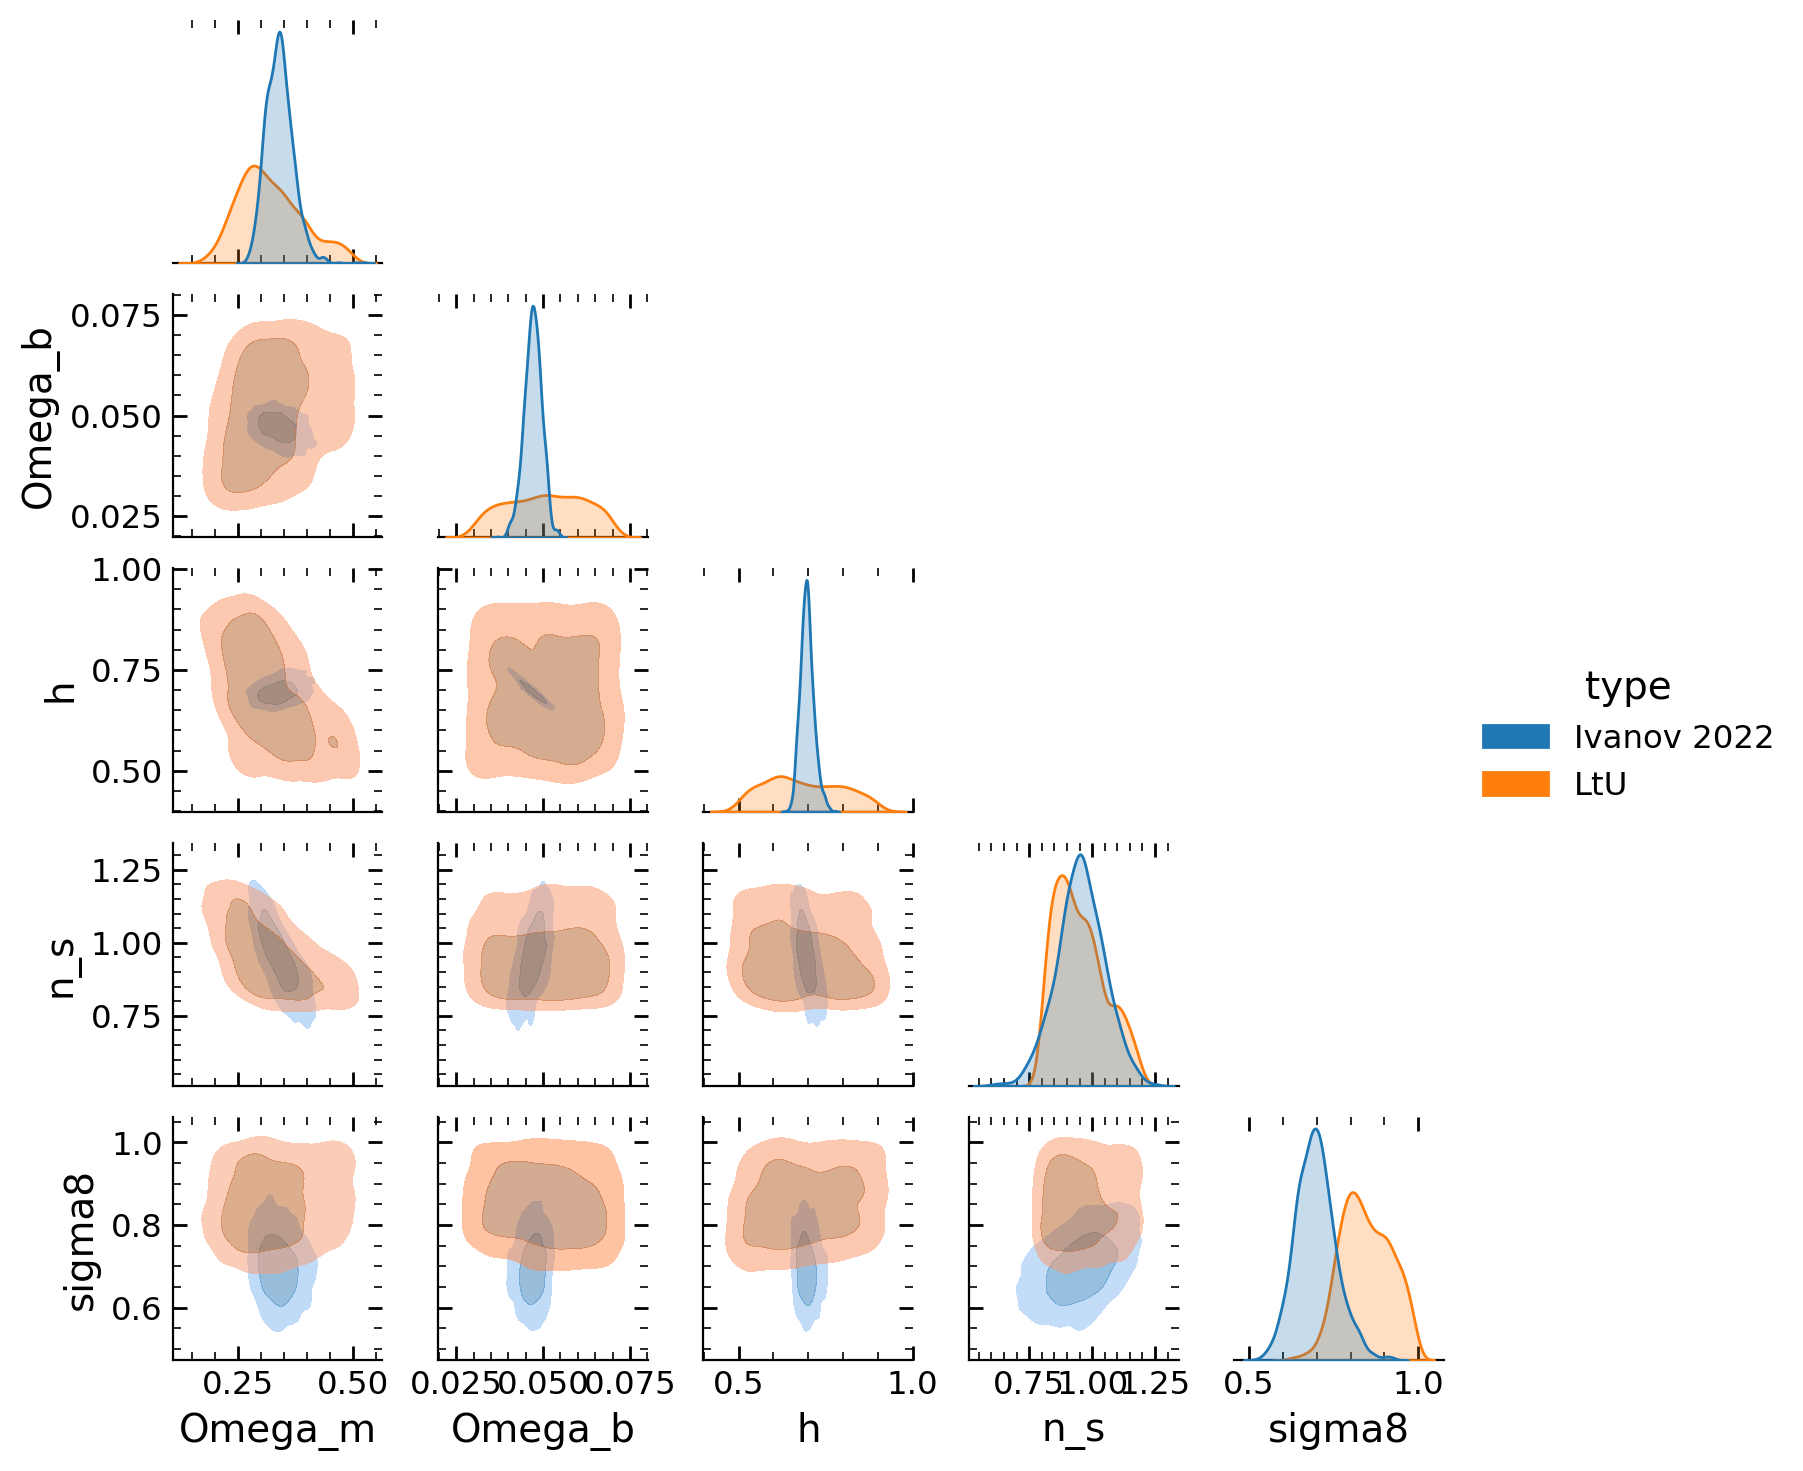

In [75]:
# Create a pairplot of the samples with specified KDE levels and fill, using latex names as axis labels
import seaborn as sns
sns.pairplot(
    out,
    hue='type',
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True, 'common_norm':False},
    corner=True,
    height=1.5  # Adjust the height to make the figure smaller
)

## Predict across many

In [76]:
def load_and_predict(summaries=['Pk0'], kmax=0.1):
    # Specify data dtype
    tracer = 'mtng_lightcone'
    summary = '+'.join(summaries)
    kmax = 0.4
    modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
    
    # Load model posterior
    with open(join(modelpath, 'posterior.pkl'), 'rb') as f:
        posterior = pickle.load(f).to('cuda')
        
    # Load an observed summary
    simpath = join(wdir, 'mtng', 'nbody', 'L3000-N384', '0', 'diag')
    with h5py.File(join(simpath, 'mtng_lightcone/hod00000_aug00000.h5'), 'r') as f:
        k = f['Pk_k3D'][:]
        Pk0 = f['Pk'][:, 0]  # get the monopole
    summ = {'k': k, 'value': Pk0}
    
    # Preprocess the summary
    from cmass.infer.loaders import preprocess_Pk
    xin = preprocess_Pk([summ], kmax)[0]
    
    # Predict
    sampobs = posterior.sample(x=xin, shape=(1000,)).to('cpu')
    return sampobs

INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1411it [00:00, 15947.62it/s]           
Drawing 216 posterior samples: 244it [00:00, 5977.06it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1389it [00:00, 15788.66it/s]           
Drawing 216 posterior samples: 231it [00:00, 5673.06it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1413it [00:00, 16090.29it/s]           
Drawing 216 posterior samples: 238it [00:00, 5844.28it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1408it [00:00, 16006.49it/s]           
Drawing 216 posterior samples: 227it [00:00, 5577.50it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1410it [00:00, 16026.15it/s]           
Drawing 216 posterior samples: 259it [00:00, 6379.34it/s]             


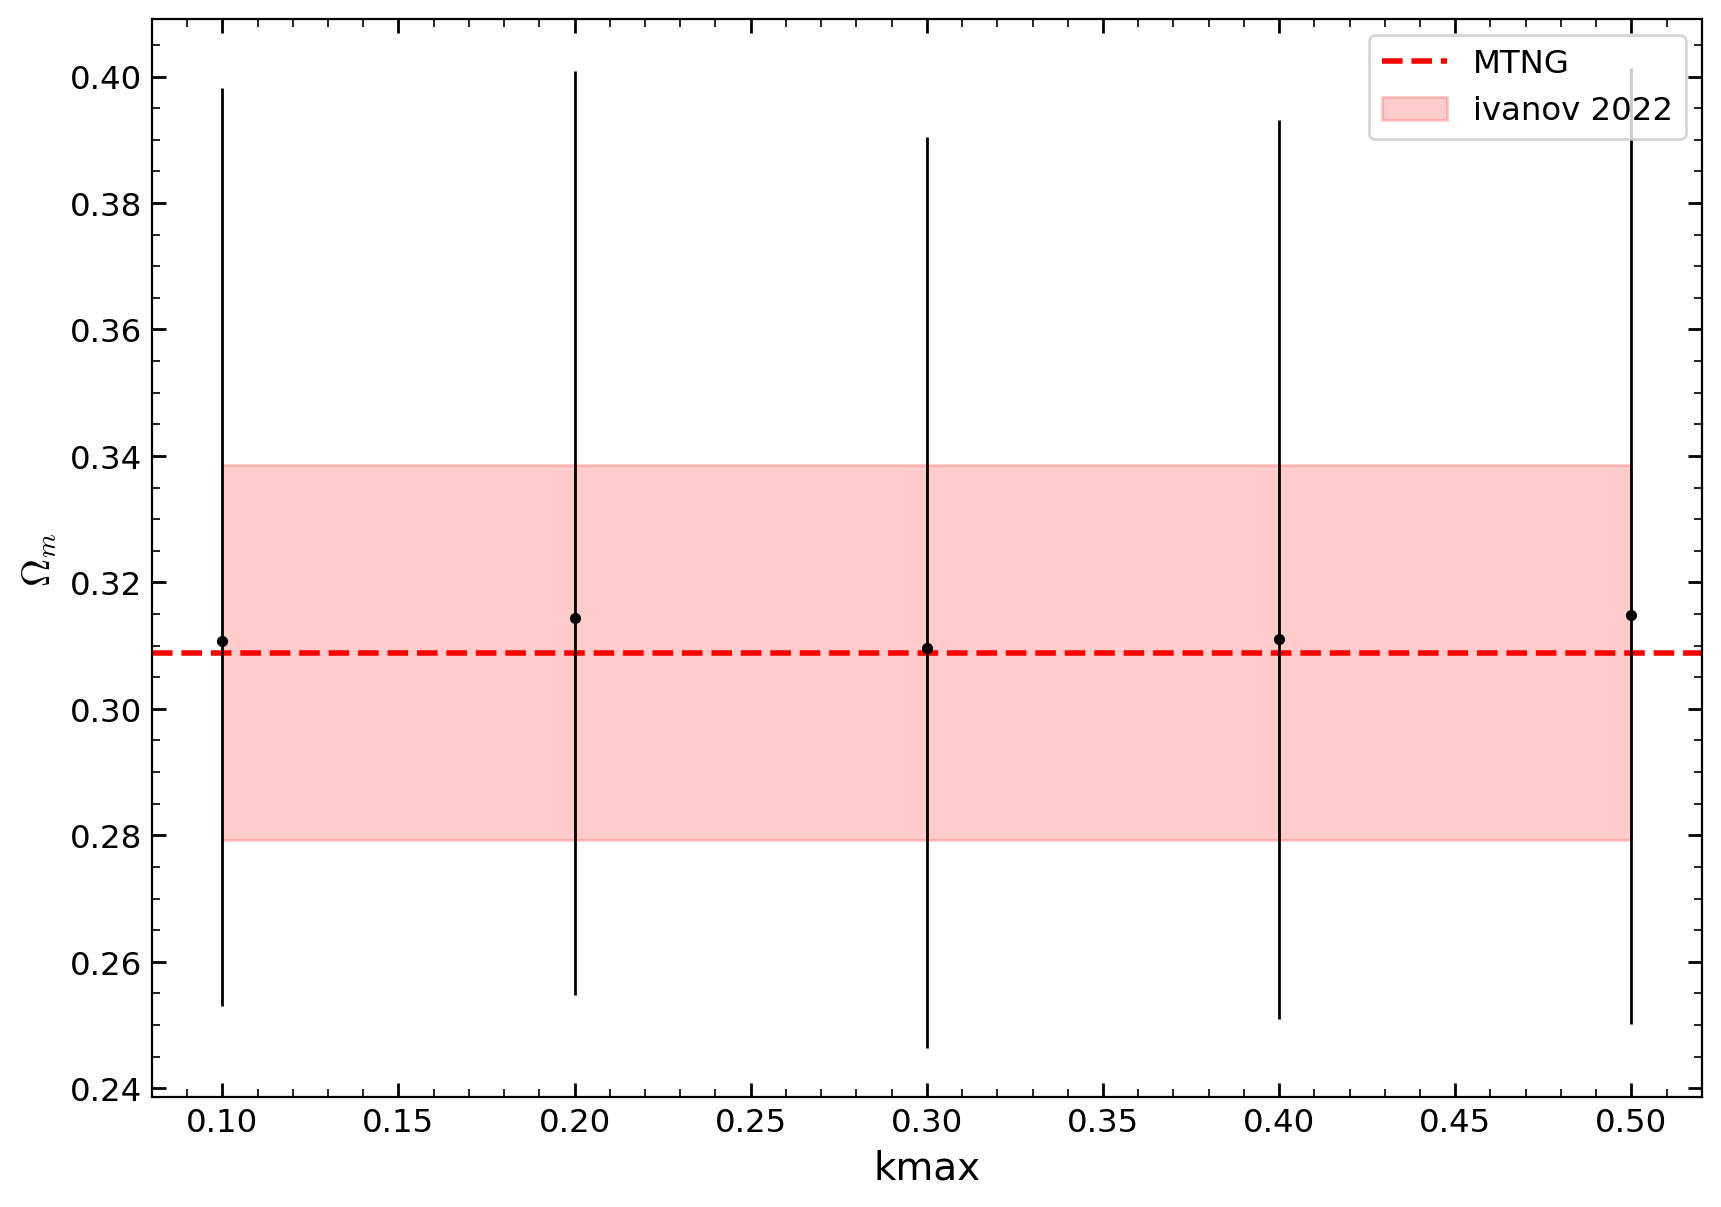

In [94]:
f, ax = plt.subplots(figsize=(10,7))
ax.axhline(mtngcosmo[0], color='r', ls='--', label='MTNG')
ivastd = iva['Omega_m'].std()
ax.fill_between([0.1,0.5], [mtngcosmo[0]-ivastd]*2, [mtngcosmo[0]+ivastd]*2, alpha=0.2, color='r', label='ivanov 2022')

for k in [0.1, 0.2, 0.3 ,0.4, 0.5]:
    sampobs = load_and_predict(kmax=k)
    percs = np.percentile(sampobs, [16,50,84], axis=0)
    ax.plot(k, percs[1,0], 'k.')
    ax.errorbar(k, percs[1,0], yerr=[[percs[1,0]-percs[0,0]], [percs[2,0]-percs[1,0]]], ecolor='k', elinewidth=1)
    ax.set(xlabel='kmax', ylabel=cosmonames[0])
ax.legend();

INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1401it [00:00, 15829.01it/s]           
Drawing 216 posterior samples: 228it [00:00, 5605.88it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1414it [00:00, 16031.17it/s]           
Drawing 216 posterior samples: 241it [00:00, 5888.41it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1395it [00:00, 15853.29it/s]           
Drawing 216 posterior samples: 242it [00:00, 5937.43it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1413it [00:00, 16079.85it/s]           
Drawing 216 posterior samples: 223it [00:00, 5476.62it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1408it [00:00, 16026.08it/s]           
Drawing 216 posterior samples: 219it [00:00, 5378.10it/s]             


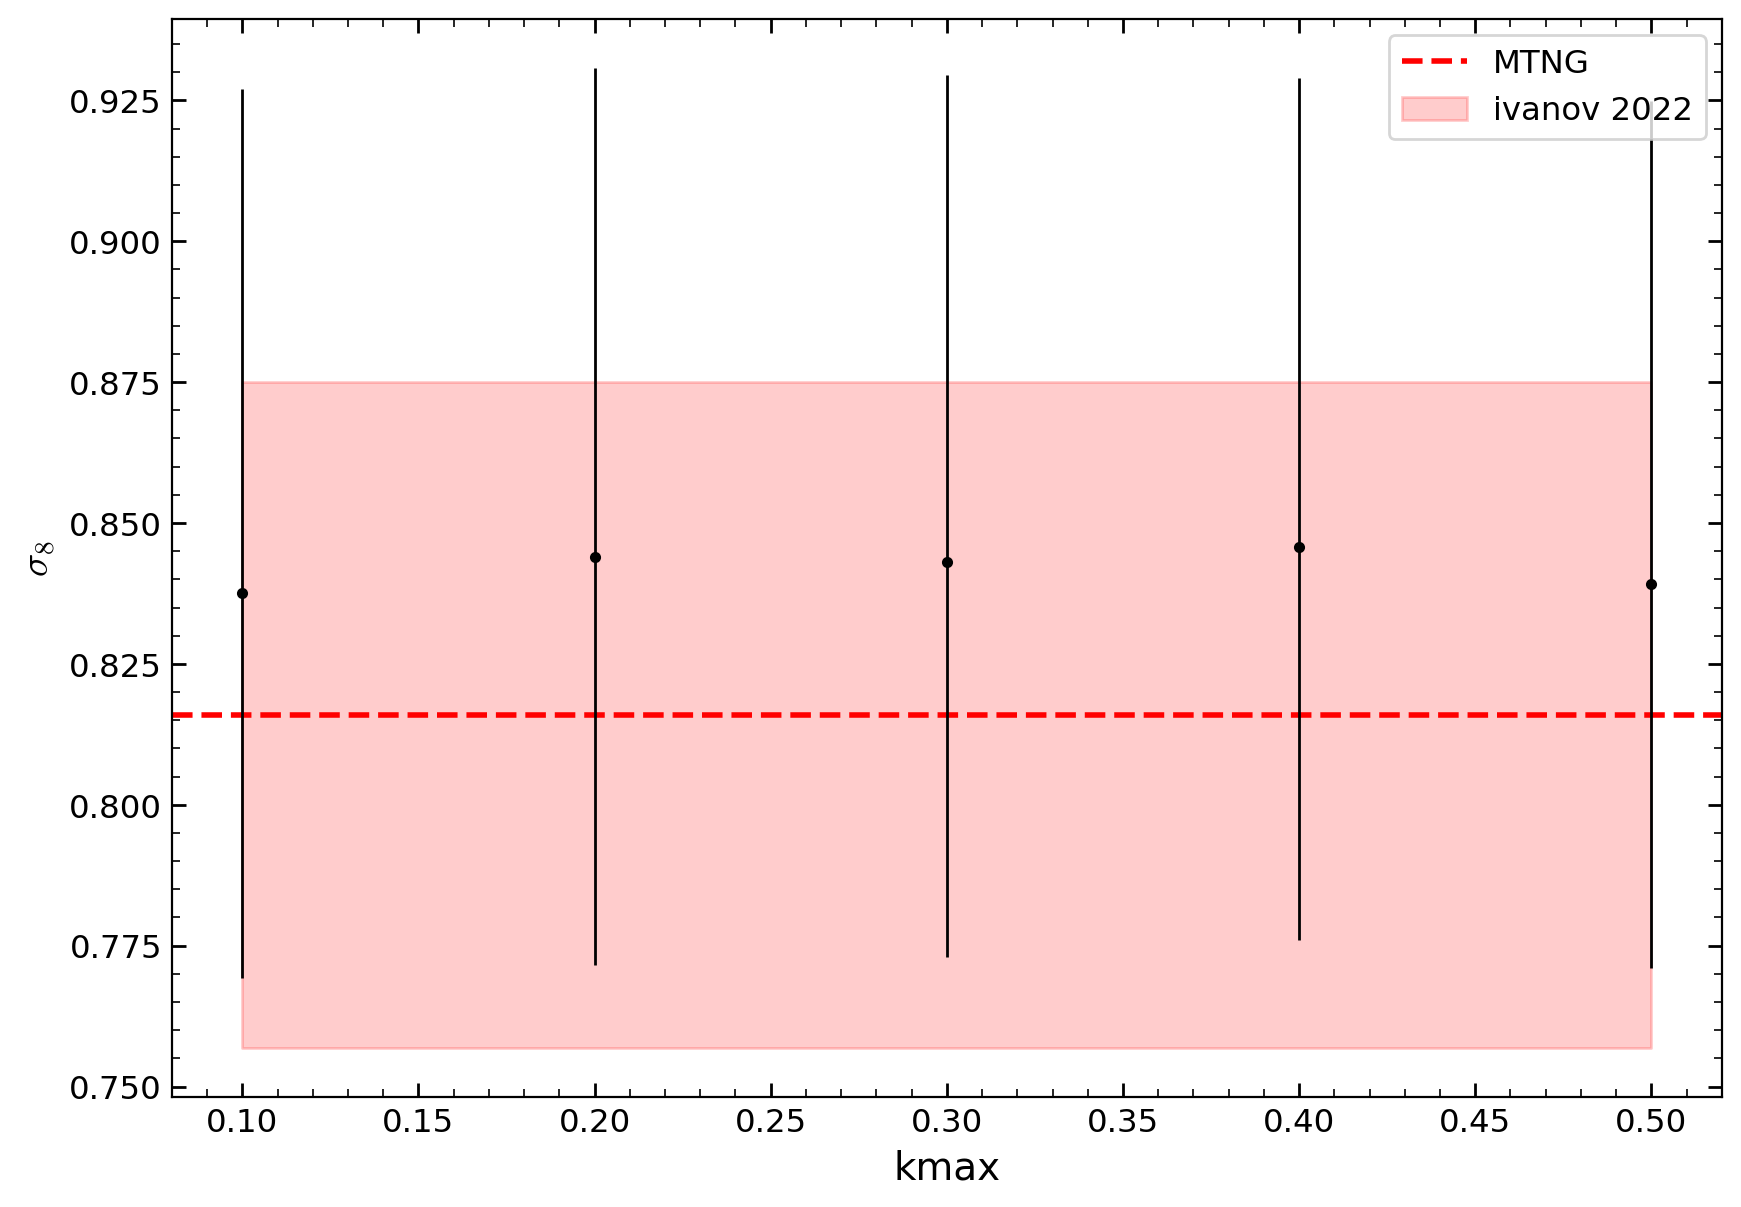

In [95]:
f, ax = plt.subplots(figsize=(10,7))
ax.axhline(mtngcosmo[4], color='r', ls='--', label='MTNG')
ivastd = iva['sigma8'].std()
ax.fill_between([0.1,0.5], [mtngcosmo[4]-ivastd]*2, [mtngcosmo[4]+ivastd]*2, alpha=0.2, color='r', label='ivanov 2022')


for k in [0.1, 0.2, 0.3 ,0.4, 0.5]:
    sampobs = load_and_predict(kmax=k)
    percs = np.percentile(sampobs, [16,50,84], axis=0)
    ax.plot(k, percs[1,4], 'k.')
    ax.errorbar(k, percs[1,4], yerr=[[percs[1,4]-percs[0,4]], [percs[2,4]-percs[1,4]]], ecolor='k', elinewidth=1)
ax.set(xlabel='kmax', ylabel=cosmonames[4])
ax.legend();

INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1405it [00:00, 15796.12it/s]           
Drawing 216 posterior samples: 225it [00:00, 5491.11it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1409it [00:00, 15941.21it/s]           
Drawing 216 posterior samples: 228it [00:00, 5557.08it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1413it [00:00, 16172.75it/s]           
Drawing 216 posterior samples: 255it [00:00, 6275.47it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1431it [00:00, 16502.43it/s]           
Drawing 216 posterior samples: 279it [00:00, 6864.21it/s]             
INFO:root:Sampling models with [784, 216] samples each.
Drawing 784 posterior samples: 1397it [00:00, 16099.01it/s]           
Drawing 216 posterior samples: 243it [00:00, 5970.24it/s]             
/tmp/ipyke

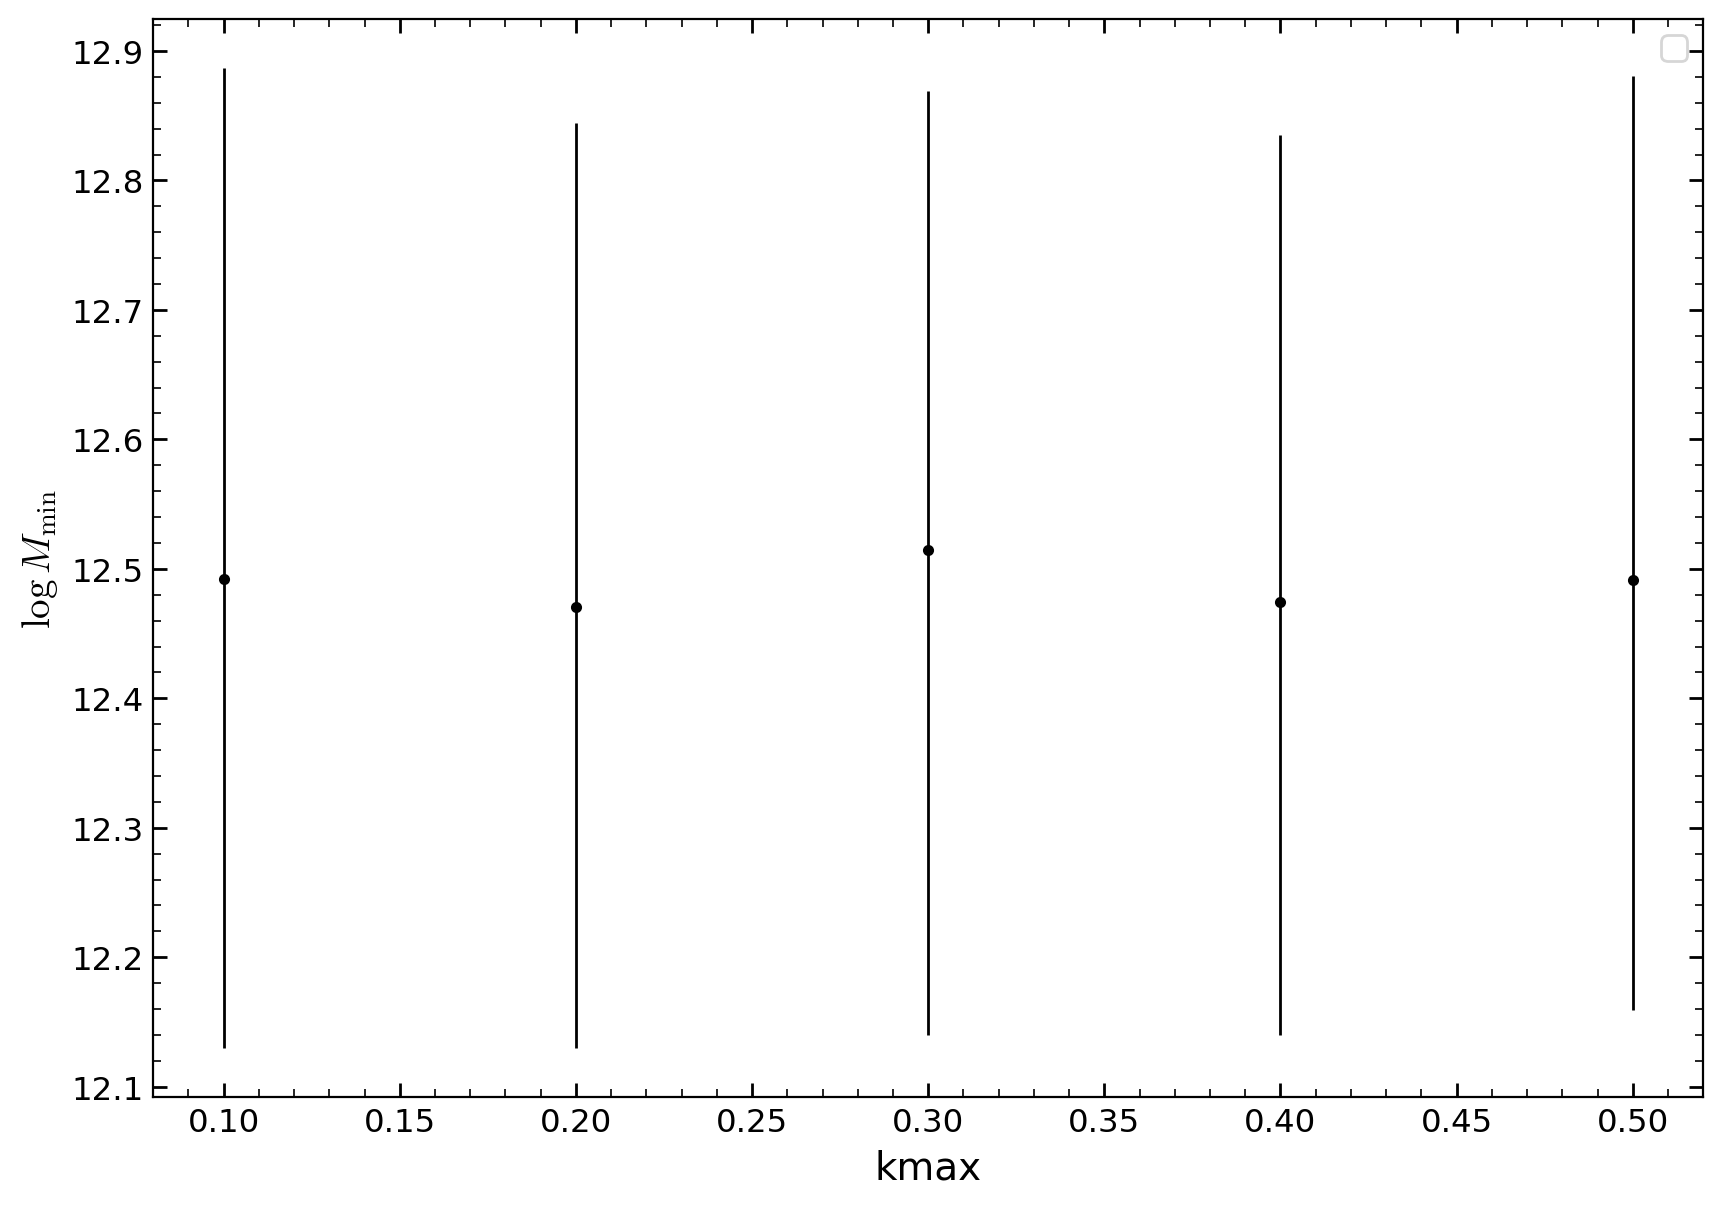

In [109]:
f, ax = plt.subplots(figsize=(10,7))
# ax.axhline(mtngcosmo[4], color='r', ls='--', label='MTNG')
# ivastd = iva['sigma8'].std()
# ax.fill_between([0.1,0.5], [mtngcosmo[4]-ivastd]*2, [mtngcosmo[4]+ivastd]*2, alpha=0.2, color='r', label='ivanov 2022')

paramind = -2
for k in [0.1, 0.2, 0.3 ,0.4, 0.5]:
    sampobs = load_and_predict(kmax=k)
    percs = np.percentile(sampobs, [16,50,84], axis=0)
    ax.plot(k, percs[1,paramind], 'k.')
    ax.errorbar(k, percs[1,paramind], yerr=[[percs[1,paramind]-percs[0,paramind]], [percs[2,paramind]-percs[1,paramind]]], ecolor='k', elinewidth=1)
ax.set(xlabel='kmax', ylabel=names[paramind])
ax.legend();

sampobs

In [106]:
sampobs.shape

torch.Size([1000, 10])